In [1]:
!pip install -q -U num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 13.7 MB/s eta 0:00:00


In [2]:
!pip install -q evaluate bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00


In [3]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import num2words
import torch
import torch.nn as nn
from transformers import ViTModel, AutoImageProcessor
from transformers.modeling_outputs import BaseModelOutput
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torchvision.transforms import functional as F_transforms
from huggingface_hub import PyTorchModelHubMixin

In [21]:
model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    # torch_dtype=torch.bfloat16,
    device_map="cuda",
)

processor.image_processor.max_image_size["longest_edge"]= 384
processor.image_processor.do_image_splitting=False
processor.image_processor.do_resize=True

for param in model.parameters():
    param.requires_grad = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
from vision_encoder import MultiCropVisionEncoder

vision_tower = ViTModel.from_pretrained("MehdiJmlkh/SmolDriverVisionTower-FT").to(device= "cuda:0")
vision_tower.embeddings.patch_embeddings = vision_tower.embeddings.patch_embeddings
vision_model = MultiCropVisionEncoder.from_pretrained("MehdiJmlkh/SmolDriverVision-FT", vision_tower = vision_tower).to("cuda")

old_vision_model = model.model.vision_model
model.model.vision_model = vision_model

Some weights of the model checkpoint at MehdiJmlkh/SmolDriverVisionTower-FT were not used when initializing ViTModel: ['encoder.layer.0.attention.attention.key.base_layer.bias', 'encoder.layer.0.attention.attention.key.base_layer.weight', 'encoder.layer.0.attention.attention.key.lora_A.default.weight', 'encoder.layer.0.attention.attention.key.lora_B.default.weight', 'encoder.layer.0.attention.attention.query.base_layer.bias', 'encoder.layer.0.attention.attention.query.base_layer.weight', 'encoder.layer.0.attention.attention.query.lora_A.default.weight', 'encoder.layer.0.attention.attention.query.lora_B.default.weight', 'encoder.layer.0.attention.attention.value.base_layer.bias', 'encoder.layer.0.attention.attention.value.base_layer.weight', 'encoder.layer.0.attention.attention.value.lora_A.default.weight', 'encoder.layer.0.attention.attention.value.lora_B.default.weight', 'encoder.layer.0.attention.output.dense.base_layer.bias', 'encoder.layer.0.attention.output.dense.base_layer.weight

In [23]:
from peft import LoraConfig, get_peft_model
from transformers import Trainer, TrainingArguments
from peft import PeftModel

peft_model = PeftModel.from_pretrained(model, "MehdiJmlkh/SmolDriver-Peft", is_trainable=False)

In [7]:
from datasets import load_dataset
import json
from datasets import Dataset

drive_lm = load_dataset("MehdiJmlkh/DriveLM")
nuscenes = load_dataset("MehdiJmlkh/nuscenes")

class DriveLM:
    def __init__(self, drive_lm, nuscenes):
        self.drive_lm = drive_lm
        self.nuscenes = nuscenes

    def __getitem__(self, idx):
      sample = self.drive_lm[idx]
      nuscenes_index = sample["nuscenes_index"]
      sample['images'] = self.nuscenes[nuscenes_index]

      return sample

    def __len__(self):
        return len(self.drive_lm)

README.md:   0%|          | 0.00/718 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/257k [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/246k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/106338 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13292 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/13293 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/703 [00:00<?, ?B/s]

data/train-00000-of-00006.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

data/train-00001-of-00006.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

data/train-00002-of-00006.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

data/train-00003-of-00006.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

data/train-00004-of-00006.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

data/train-00005-of-00006.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/355M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/422 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/411 [00:00<?, ? examples/s]

In [8]:
test_dataset = DriveLM(drive_lm["test"], nuscenes["test"])

In [9]:
from torch.utils.data import Dataset

class VLMQADataset(Dataset):
    def __init__(self, dataset: DriveLM, is_train=True):
        self.dataset = dataset
        self.is_train = is_train

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        user_msg = []
        cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
        for camera in cameras:
            user_msg.extend([
                {"type": "text", "text": camera},
                {"type": "image", "image": item["images"][camera]}
            ])

        user_msg.append({
            "type": "text",
            "text":f"Scene description:{item['scene_description']} Question: {item['question']}"
        })

        assistant_msg = [{"type": "text", "text": item["answer"]}]

        if not self.is_train:
            conversation = [
                {
                    "role": "user",
                    "content": user_msg
                }
            ]
            return self.__apply_chat_template(conversation, True)


        conversation = [
            {
                "role": "user",
                "content": user_msg
            },
            {
                "role": "assistant",
                "content": assistant_msg
            }
        ]
        inputs = self.__apply_chat_template(conversation)

        label_start_idx = self.__get_label_start_idx(inputs)

        labels = inputs['input_ids'].clone()
        labels[:, :label_start_idx] = -100
        inputs['labels'] = labels

        return inputs

    def __apply_chat_template(self, conversation, add_generation_prompt=False):
        return processor.apply_chat_template(
            conversation,
            add_generation_prompt=add_generation_prompt,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        )

    def __get_label_start_idx(self, inputs):
        utterance_id = processor.tokenizer.convert_tokens_to_ids('<end_of_utterance>')
        utterance_idx = inputs['input_ids'][0].tolist().index(utterance_id)
        num_assistant_ids = 4
        label_idx = utterance_idx + num_assistant_ids + 1

        return label_idx


In [11]:
test_ds = VLMQADataset(test_dataset, is_train=False)

In [14]:
import matplotlib.pyplot as plt

def display_sample_and_output(index, model):
    sample = test_dataset[index]

    def display_image(image, title):
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)

    plt.figure(figsize=(20, 8))
    cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
    for i, camera in enumerate(cameras):
        plt.subplot(2, 3, i + 1)
        display_image(sample['images'][camera], camera)
    plt.tight_layout()
    plt.show()

    for key, value in sample.items():
        if type(value) is str:
            print(f"{key}: {value}")

    output = model.generate(**test_ds[index].to("cuda", dtype=torch.bfloat16), max_new_tokens=32)
    generated_texts = processor.batch_decode(output, skip_special_tokens=True)
    print("model answer: " + generated_texts[0].split("Assistant: ")[-1])

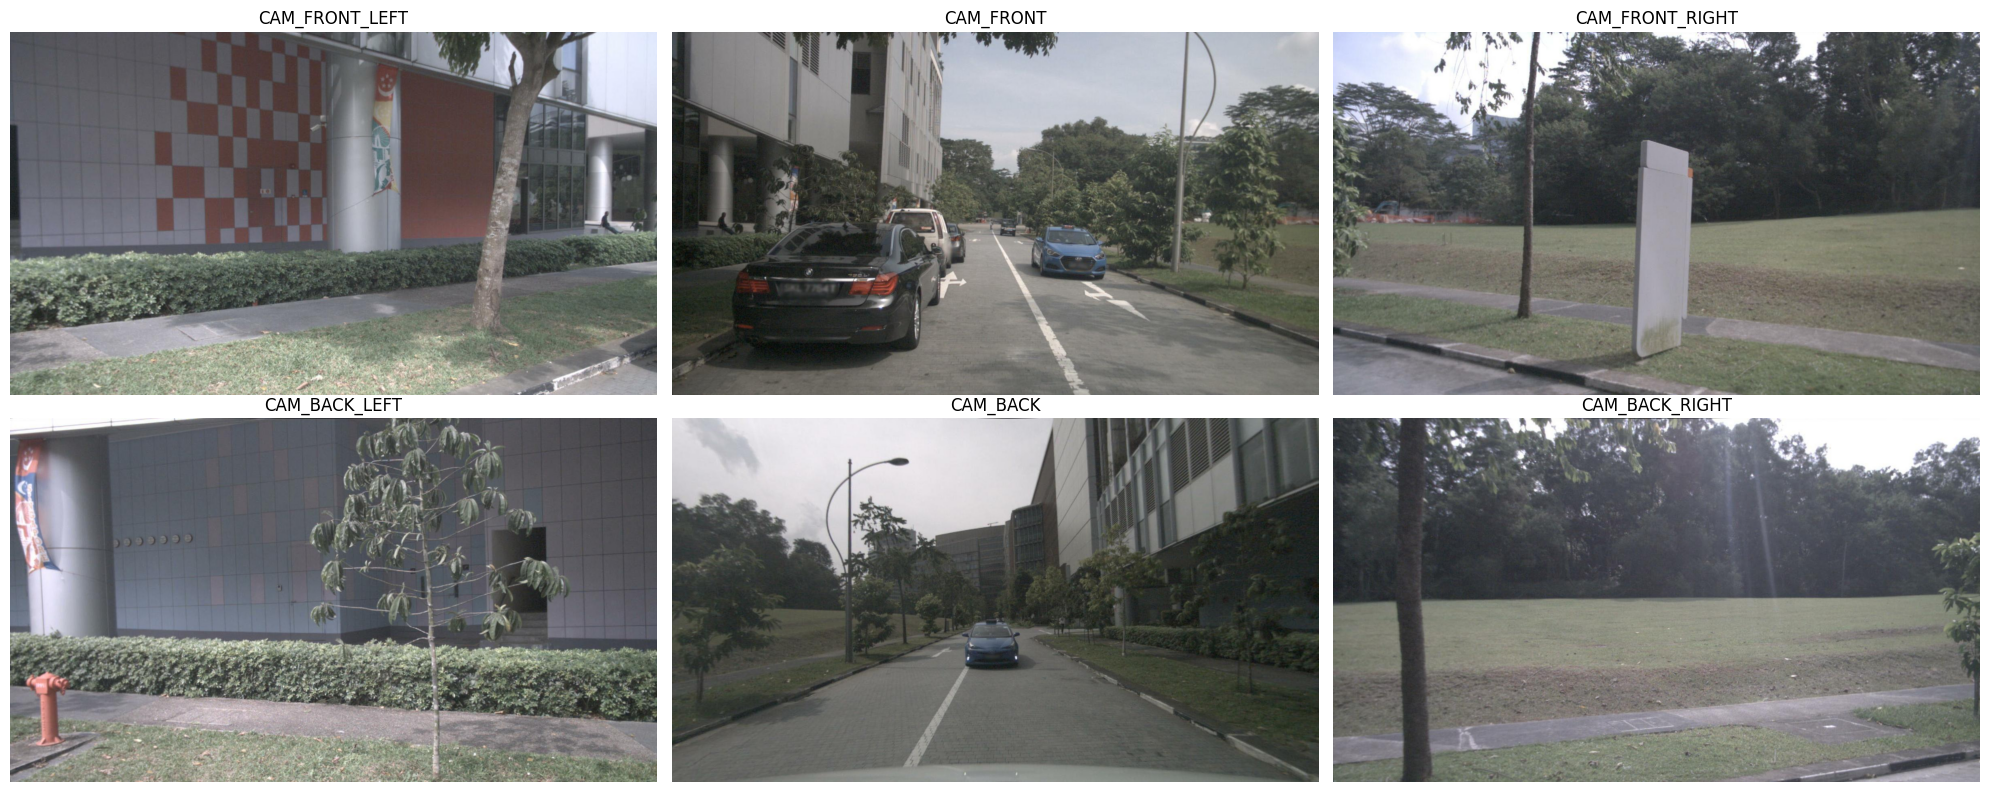

scene_token: 1c89941a6935484182ca19eddcd3bc77
frame_token: d88aa76156b24f4580004bcf438a4303
scene_description: The ego vehicle proceeds along the current road, halts and awaits the passage of the vehicles on the right side.
task: perception
question: What are objects to the front of the ego car?
answer: There are many cars and one pedestrian in front of the ego car.


RuntimeError: mat1 and mat2 must have the same dtype, but got BFloat16 and Float

In [24]:
display_sample_and_output(10, model)

In [ ]:
import matplotlib.pyplot as plt

refs=[]
preds=[]

for index in range(0, len(test_ds), 10):
    sample = test_dataset["test"][index]

    refs.append(sample['answer'])


    output = model.generate(**test_ds[index].to("cuda", dtype=torch.bfloat16), max_new_tokens=32)
    generated_texts = processor.batch_decode(output, skip_special_tokens=True)
    preds.append(generated_texts[0].split("Assistant: ")[-1])
    print(".", end="")

In [ ]:
import evaluate

bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

bleu_result = bleu.compute(predictions=preds, references=refs)

bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")

scores = {
      "BLEU": bleu_result["bleu"],
      "BERTScore_P": sum(bert_result["precision"]) / len(bert_result["precision"]),
      "BERTScore_R": sum(bert_result["recall"]) / len(bert_result["recall"]),
      "BERTScore_F1": sum(bert_result["f1"]) / len(bert_result["f1"])
    }